# How does the educational background of parents influence the academic performance of students in final exams, as well as their interest in pursuing higher education? Specifically, do students whose parents have higher levels of education (e.g., secondary education or higher) perform better in their final exams compared to those whose parents have lower levels of education? Additionally, do students from higher-educated families demonstrate a stronger interest in pursuing higher education themselves? 

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV

In [2]:
# Loading data from SQLite DB
sqlite_db_path = "../student_performance.db"
conn = sqlite3.connect(sqlite_db_path)

In [3]:
conn = sqlite3.connect(sqlite_db_path)
query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query_tables, conn)
print(tables)


          name
0  student_mat
1  student_por


In [4]:
# Query to fetch data from two tables
query_mat = "SELECT * FROM student_mat"
df_mat = pd.read_sql(query_mat, conn)

query_por = "SELECT * FROM student_por"
df_por = pd.read_sql(query_por, conn)

In [5]:
# Combining the two datasets
df = pd.concat([df_mat, df_por], ignore_index=True)
conn.close()

print("Loaded Data Preview (Merged Student Data):")
display(df.head())

Loaded Data Preview (Merged Student Data):


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [6]:
# Data Preprocessing
df = df.dropna(subset=['G3'])  # Remove rows with missing final exam scores

# Encoding categorical features
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [7]:
# Normalizing numerical features (excluding grade columns)
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
grade_cols = ['G1', 'G2', 'G3']
numeric_cols = [col for col in numeric_cols if col not in grade_cols]
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [8]:
# Feature Engineering
df['sudden_grade_drop'] = df['G1'] - df['G2']
df['attendance_engagement'] = df['absences'] / (df['G1'] + df['G2'] + df['G3'] + 1)
df['low_engagement_flag'] = (df['attendance_engagement'] > df['attendance_engagement'].quantile(0.75)).astype(int)


In [9]:
# Categorizing the final grades into three categories
def categorize_g3(grade):
    if grade < 10:
        return 0  # Low
    elif 10 <= grade < 15:
        return 1  # Medium
    else:
        return 2  # High

df['G3_category'] = df['G3'].apply(categorize_g3)

In [10]:
# Defining features and target variable
X = df.drop(columns=['G3', 'G3_category'])
y = df['G3_category']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [11]:
# Baseline Logistic Regression Model
log_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
log_accuracy = accuracy_score(y_test, y_pred_log)

# Logistic Regression Model Evaluation
print("Logistic Regression Model Evaluation:")
print("Accuracy:", log_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_log))

Logistic Regression Model Evaluation:
Accuracy: 0.8755980861244019
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84        46
           1       0.89      0.90      0.89       122
           2       0.85      0.85      0.85        41

    accuracy                           0.88       209
   macro avg       0.87      0.86      0.86       209
weighted avg       0.88      0.88      0.88       209



In [12]:
# Baseline Decision Tree Model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)

# Decision Tree Model Evaluation
print("Decision Tree Model Evaluation:")
print("Accuracy:", tree_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))

Decision Tree Model Evaluation:
Accuracy: 0.8038277511961722
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74        46
           1       0.84      0.82      0.83       122
           2       0.82      0.78      0.80        41

    accuracy                           0.80       209
   macro avg       0.79      0.79      0.79       209
weighted avg       0.81      0.80      0.80       209



In [13]:
# Drop rows with missing target values (G3, the final grade)
df = df.dropna(subset=['G3'])

# Encode categorical variables (e.g., parents' education level)
df['Medu_level'] = df['Medu'].apply(lambda x: 'None' if x == 0 else ('Primary' if x == 1 else ('Secondary' if x == 2 else 'Higher')))
df['Fedu_level'] = df['Fedu'].apply(lambda x: 'None' if x == 0 else ('Primary' if x == 1 else ('Secondary' if x == 2 else 'Higher')))


In [14]:
# Check if the target variable (final grade) has missing values
df['Medu_level'].value_counts(), df['Fedu_level'].value_counts()

(Medu_level
 Higher    1044
 Name: count, dtype: int64,
 Fedu_level
 Higher    1044
 Name: count, dtype: int64)

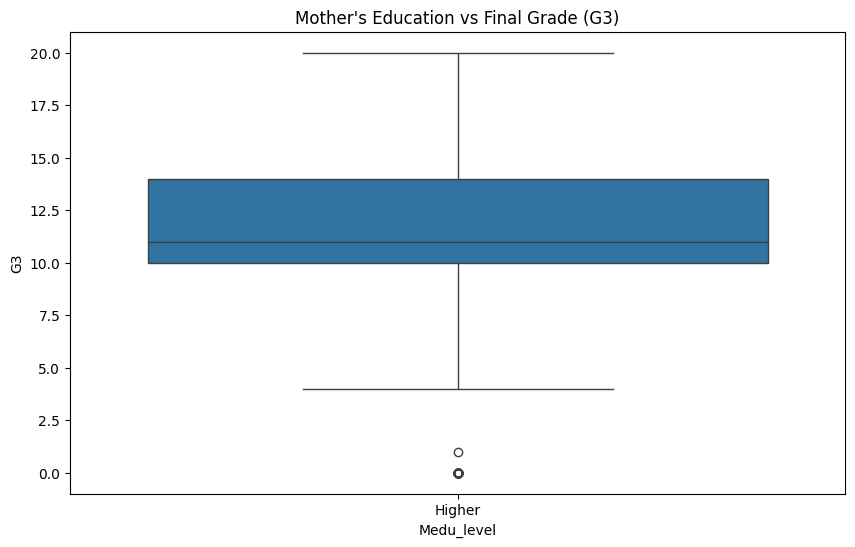

In [15]:
# Plotting the correlation between parental education and student performance
plt.figure(figsize=(10, 6))

# Plotting G3 vs Medu (Mother's education)
sns.boxplot(x='Medu_level', y='G3', data=df)
plt.title('Mother\'s Education vs Final Grade (G3)')

# Save the plot as an image (e.g., PNG)
plt.savefig('../Visualizations/mother_education_vs_final_grade.png', dpi=300, bbox_inches='tight')

plt.show()

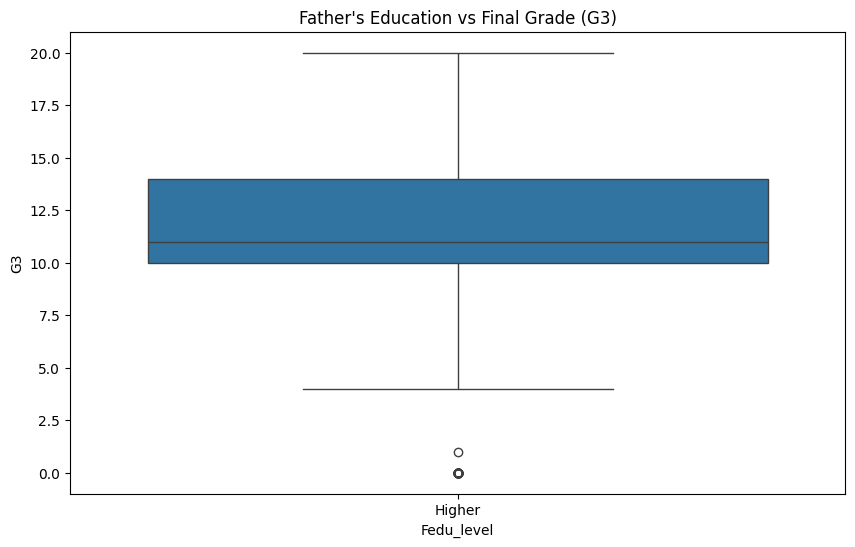

In [16]:
# Plotting G3 vs Fedu (Father's education)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fedu_level', y='G3', data=df)
plt.title('Father\'s Education vs Final Grade (G3)')

plt.savefig('../Visualizations/Father\'s Education vs Final Grade.png', dpi=300, bbox_inches='tight')

plt.show()

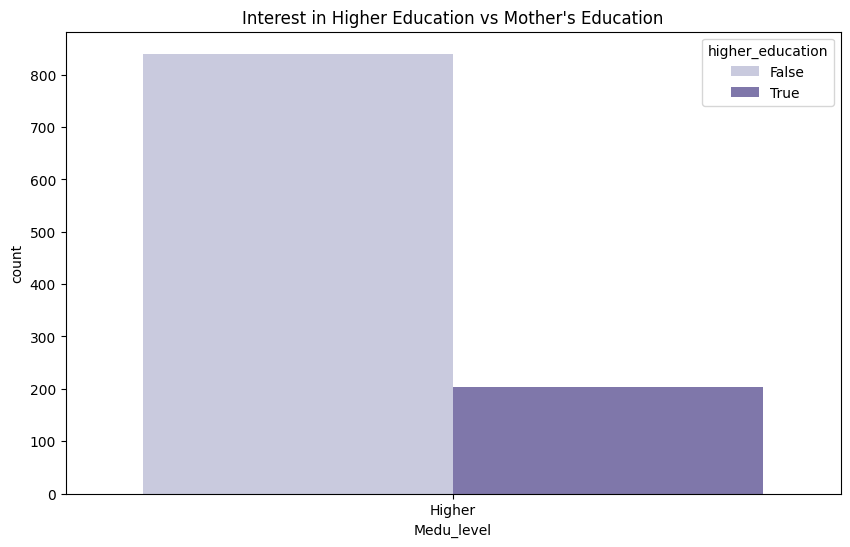

In [29]:
# Analyzing if students from higher-educated families are more likely to pursue higher education (assuming higher education is categorized in a binary format)
df['higher_education'] = df['G3'] >= 15  # assuming students with G3 >= 15 are considered as more likely to pursue higher education

# Plotting the data for students' interest in higher education based on parent's education level
plt.figure(figsize=(10, 6))
sns.countplot(x='Medu_level', hue='higher_education', data=df, palette='Purples')
# Remove the background color
ax.set_facecolor('none')  # Makes the plot area transparent
plt.title('Interest in Higher Education vs Mother\'s Education')

plt.savefig('../Visualizations/Interest in Higher Education vs Mother\'s Education.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

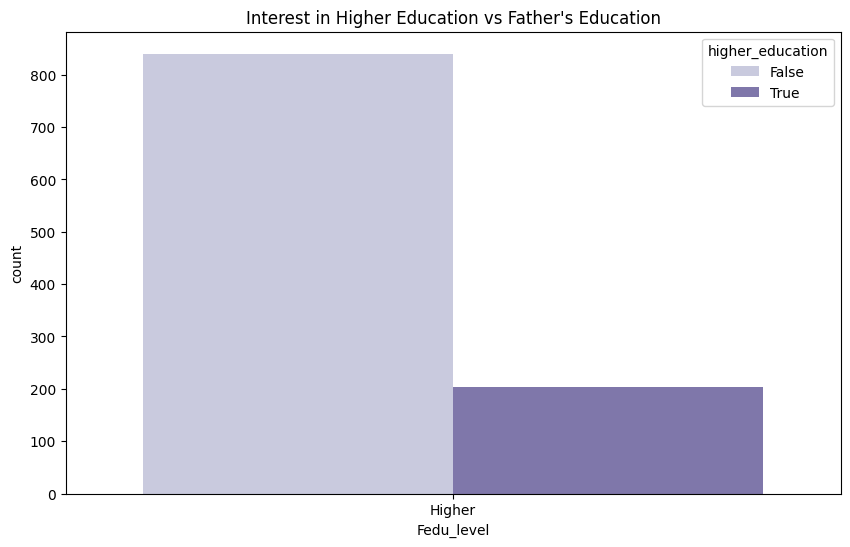

In [27]:
plt.figure(figsize=(10, 6), facecolor='none')  # Transparent background
ax = sns.countplot(x='Fedu_level', hue='higher_education', data=df, palette='Purples')

# Remove the background color
ax.set_facecolor('none')  # Makes the plot area transparent
plt.title("Interest in Higher Education vs Father's Education")

# Save with a transparent background
plt.savefig('../Visualizations/Interest_vs_Father_Edu.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()


In [19]:
# Encoding categorical features for modeling
df_encoded = pd.get_dummies(df[['Medu_level', 'Fedu_level', 'G1', 'G2', 'absences']], drop_first=True)

# Target variable: whether the student is interested in higher education (G3 >= 15)
y = (df['G3'] >= 15).astype(int)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)


In [20]:
# Logistic Regression Model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Make predictions
y_pred_log = log_model.predict(X_test)

# Evaluate the Logistic Regression model
print("Logistic Regression Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:")
print(classification_report(y_test, y_pred_log))


Logistic Regression Model Evaluation:
Accuracy: 0.9712918660287081
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       166
           1       1.00      0.86      0.93        43

    accuracy                           0.97       209
   macro avg       0.98      0.93      0.95       209
weighted avg       0.97      0.97      0.97       209



In [21]:
# Decision Tree Model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Make predictions
y_pred_tree = tree_model.predict(X_test)

# Evaluate the Decision Tree model
print("Decision Tree Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))

Decision Tree Model Evaluation:
Accuracy: 0.9712918660287081
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       166
           1       1.00      0.86      0.93        43

    accuracy                           0.97       209
   macro avg       0.98      0.93      0.95       209
weighted avg       0.97      0.97      0.97       209



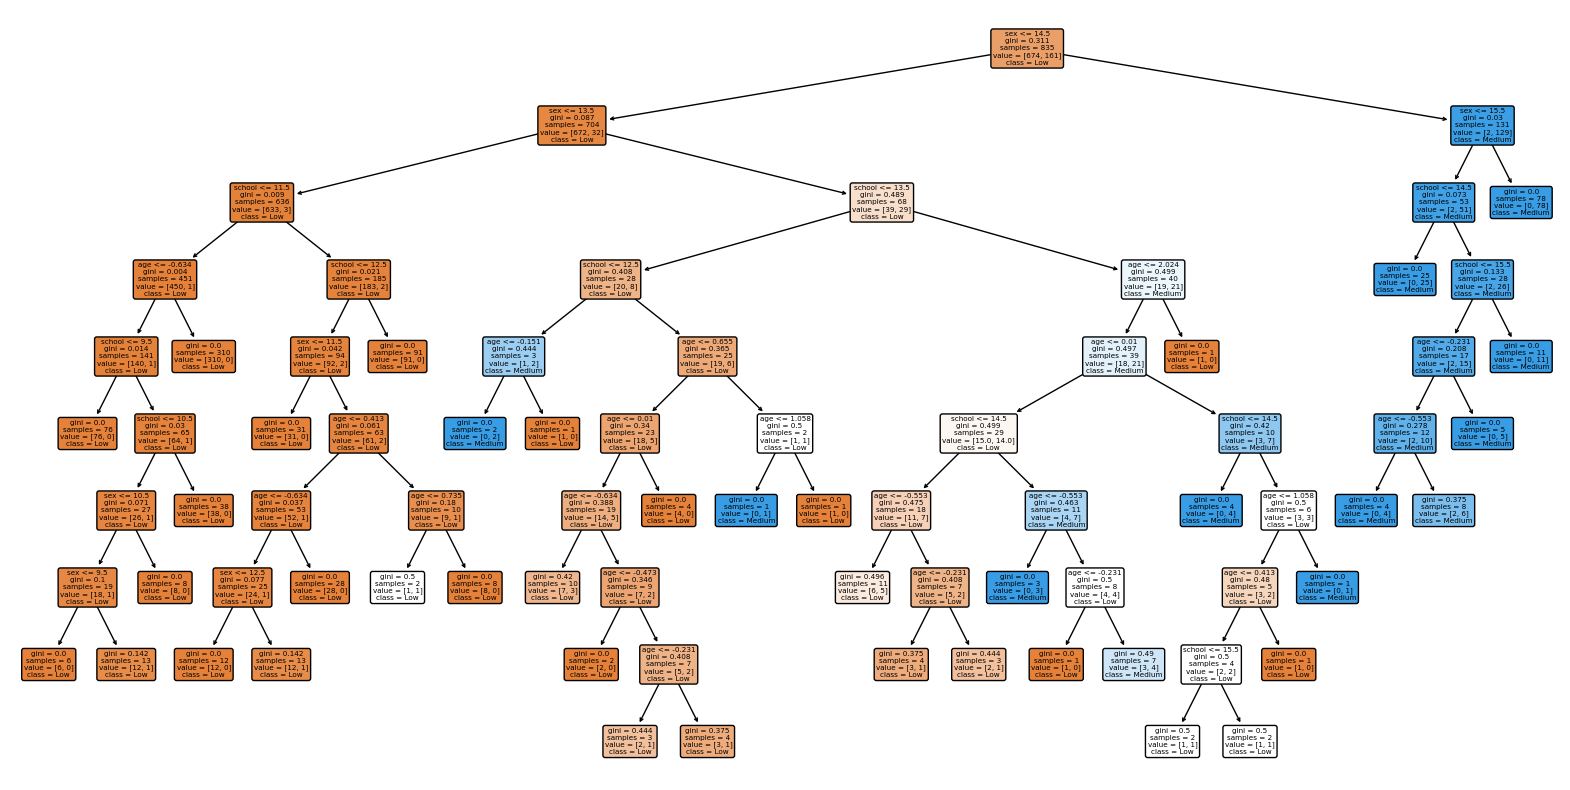

In [32]:
# Define the figure and axes
fig, ax = plt.subplots(figsize=(20, 10))

# Remove the background color
ax.set_facecolor('none')  # Makes the plot area transparent

# Title for the plot
plt.title("Decision Tree Model for Predicting Student Outcomes")

# Plot the decision tree
plot_tree(tree_model, filled=True, feature_names=X.columns, class_names=['Low', 'Medium', 'High'], rounded=True)

# Save the decision tree plot as an image (e.g., PNG)
plt.savefig('../Visualizations/decision_tree_plot.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

## Data Model Optimization

In [23]:
# Example for Logistic Regression Hyperparameter Tuning
param_grid = {
    'C': [0.1, 1, 10],              # Regularization strength
    'solver': ['lbfgs'],             # Use 'lbfgs', which supports multinomial classification
    'max_iter': [500, 1000, 1500]    # Maximum number of iterations
}

grid_search = GridSearchCV(LogisticRegression(multi_class='multinomial'), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters for Logistic Regression:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters for Logistic Regression: {'C': 1, 'max_iter': 500, 'solver': 'lbfgs'}
Best Score: 0.962874251497006


In [24]:
# Using the optimized model for predictions
y_pred_log_optimized = grid_search.best_estimator_.predict(X_test)
print("Optimized Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_optimized))
print("Optimized Classification Report:")
print(classification_report(y_test, y_pred_log_optimized))

Optimized Logistic Regression Accuracy: 0.9712918660287081
Optimized Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       166
           1       1.00      0.86      0.93        43

    accuracy                           0.97       209
   macro avg       0.98      0.93      0.95       209
weighted avg       0.97      0.97      0.97       209

